# <center>3. S&P Global - Modeling training </center>

**************************************************************************************************
@autor: Diego Babativa <br />
@date: 2022-10 <br />
@Description: This modeling training notebook is the third. Here We are going to able to do the modelingtraining process <br />
**************************************************************************************************

### 1. Loading features

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.preprocessing import StandardScaler
from bayes_opt import BayesianOptimization
import shap
import wandb
import xgboost
from xgboost import cv, XGBRegressor, plot_importance

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_parquet('../../data/features/interview_dataset_features_v1.parquet')
X = df.drop(columns=['production'])
y = df['production']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 87), (200, 87), (800,), (200,))

In [5]:
X_train,X_eval,y_train,y_eval=train_test_split(X, y, test_size=0.6, random_state=10)
X_test,X_val,y_test,y_val=train_test_split(X_eval,y_eval, test_size=0.3, random_state=10)

In [6]:
model_lin_reg = LinearRegression()
model_lin_reg.fit(X_train, y_train)

LinearRegression()

In [7]:
pred_lin_reg = model_lin_reg.predict(X_test)

In [10]:
#Saving linear regression model
joblib.dump(model_lin_reg, '../../models/model_linear_regression.pkl')

['../../models/model_linear_regression.pkl']

In [36]:
loaded_model = joblib.load('../../models/model_linear_regression.pkl')

### Stablishing a  baseline MSE for the dataset. (Training)

In [6]:
# This is our "naive" predictive model, sucha as the mean target of the training set.
y_train.mean()

1939.3606045352246

In [34]:
def print_metrics(y_true, y_pred):    
    print("MAE:  ", mean_absolute_error(y_true, y_pred))
    print("MSE : ", mean_squared_error(y_true, y_pred))
    print("RMSE: ", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("RMSLE:", np.log(np.sqrt(mean_squared_error(y_true,y_pred))))
    print("R2:   ", r2_score(y_true, y_pred))

In [35]:
print_metrics(y_test, pred_lin_reg)

MAE:   633.3839678953661
MSE :  746965.793977538
RMSE:  864.271828753858
RMSLE: 6.761887335935889
R2:    0.5847194795200009


In [39]:
print_metrics(y_test, model_lin_reg.predict(X_test))

MAE:   598.217705069123
MSE :  663173.1731571073
RMSE:  814.3544517942462
RMSLE: 6.702395715688788
R2:    0.6693085166003452


In [9]:
y_test.median()

1672.0927785

In [10]:
y_test.describe()

count     420.000000
mean     1991.395363
std      1342.756338
min       199.970803
25%      1020.681637
50%      1672.092778
75%      2683.487759
max      8880.671151
Name: production, dtype: float64

In [40]:
# Approaches: linear model, after model based on decision trees
# KNN no scaling very good and SVM is not good.

### 2. Bayesian Optimization and training model with Weigh and Biasis

In [8]:
sweep_config = {
    'name':'spg-sweep-regression-xgboost',
    'method': 'bayes',
    'metric': {
      'name': 'rmse',
      'goal': 'minimize'
    },

    'parameters' : {
        'learning_rate':{'min': 0.001, 'max': 0.2},
        'max_depth':{'min': 2, 'max': 9},
        'reg_lambda': {'min': 0.1, 'max': 4.0},
        'reg_alpha':{'min': 0.1, 'max':4.0},
        'gamma':{'min':0.001, 'max':1.0},
        'n_estimators':{'min': 100, 'max': 1000},
        'min_child_weight':{'min': 1, 'max': 10},
    }
}

In [9]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'modeling.ipynb'
sweep_id = wandb.sweep(sweep_config, project='spg', entity='dbabativa')

Create sweep with ID: z8dmz4o5
Sweep URL: https://wandb.ai/dbabativa/spg/sweeps/z8dmz4o5


In [13]:
os.environ["WANDB_SILENT"] = "false"

In [ ]:
def train():
    

    with wandb.init(tags=['xgboost']) as run:

        global config
        global bst
    
        # Config is a variable that holds and saves hyperparameters and inputs
        config = wandb.config

        modelo = XGBRegressor(
            learning_rate=config.learning_rate,
            max_depth = config.max_depth,
            reg_lambda = config.reg_lambda,
            reg_alpha = config.reg_alpha,
            gamma = config.gamma,
            n_estimators = config.n_estimators,
            min_child_weight = config.min_child_weight,
            n_jobs=-1,
            eval_metric='mae',
        )
        
        modelo.fit(X_train, 
                   y_train,
                   eval_set=[(X_val, y_val)],
                   early_stopping_rounds=10, 
                   verbose=False,
                   eval_metric='mae')
  
        bst = modelo.get_booster()
        preds = modelo.predict(X_test)

        #Metric results    
        mae   = mean_absolute_error(y_test, preds)
        mse   = mean_squared_error(y_test, preds)
        rmse  = np.sqrt(mean_squared_error(y_test, preds))
        rmsle =  np.log(np.sqrt(mean_squared_error(y_test,pred_lin_reg)))
        r2    = r2_score(y_test, preds)
        
        wandb.log({
            'train mae': mae,
            'train mse': mse,    
            'train rmse': rmse,
            'train r2': r2,   
            'model': wandb.sklearn.plot_regressor(modelo, X_train, X_test, y_train, y_test, model_name="XGBoost")
            })
        return mae
            
count = 100 # number of runs
wandb.agent(sweep_id, function=train, count=count)

#### According with wandb results (https://wandb.ai/dbabativa/spg/sweeps/z8dmz4o5/table?workspace=user-dbabativa) or https://wandb.ai/dbabativa/spg/sweeps/z8dmz4o5
#### The selected model was : 'floral-sweep-34'

In [16]:
best_model_xgb    = XGBRegressor(
    learning_rate = 0.1314,
    max_depth     = 9,
    reg_lambda    = 2.37,
    reg_alpha     = 0.7761,
    gamma         = 0.9799,
    n_estimators  = 795,
    min_child_weight = 3,
    n_jobs        = -1,
    eval_metric='mae',
)
best_model_xgb.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=10,
    verbose=False,
    eval_metric='mae'
    )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='mae', gamma=0.9799, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1314, max_delta_step=0,
             max_depth=9, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=795, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.7761, reg_lambda=2.37, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
print_metrics(y_test, best_model_xgb.predict(X_test))

MAE:   563.7487701392727
MSE :  663344.0692180938 es sesgada hacia el enorme valor de conjuntos  de datos
RMSE:  814.4593723557325
RMSLE: 6.702524546326244
R2:    0.6312095245281149


In [18]:
params ={
  'gamma': 0.9799,
  'learning_rate': 0.1314,
  'max_depth': 9,
  'min_child_weight': 3,
  'reg_lambda': 2.37,
  'subsample': 0.7761,
  'reg_alpha': 0.7761
}

num_boost_round = 795

In [19]:
data_matrix= xgboost.DMatrix(data= X_train, label=y_train)
xgb_cv = cv(params=params,
    num_boost_round=num_boost_round,
    dtrain=data_matrix,
    stratified=False,
    nfold=5,
    early_stopping_rounds=10, 
    metrics="mae",
    as_pandas=True,
    seed=10)
xgb_cv.head()

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,1707.712598,22.809858,1705.766358,106.470707
1,1503.874878,20.659752,1504.854517,100.593316
2,1328.007276,22.240899,1332.786816,88.352870
3,1179.704736,18.248206,1186.477442,90.557399
4,1046.666150,18.173497,1067.921741,86.787726


In [20]:
#Saving xgboost model
joblib.dump(best_model_xgb, '../../models/model_xgboost_floral-sweep-34.pkl')

['../../models/model_xgboost_floral-sweep-34.pkl']

### Training model with another way. Max params of optimizer:


In [24]:
pbounds = {
    'learning_rate': (0.001, 0.2),
    'subsample':(0.1,1),
    'max_depth': (2,9),
    'reg_lambda': (0.1, 4),
    'reg_alpha': (0.1, 4),
    'gamma': (0.001, 1),
    'n_estimators':(100, 500),
    'mcw': (2,8)
}

In [21]:
def xgboost_hyper_param(learning_rate,
                        mcw,
                        max_depth,
                        reg_lambda,
                        reg_alpha,
                        gamma,
                        n_estimators,
                        subsample):
    
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    reg = XGBRegressor(
        use_label_encoder=False,
        n_estimators=n_estimators,
        subsample= subsample,
        n_jobs=-1, #Please, change wuth the number of cores you have !!!
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=mcw,
        reg_lambda=reg_lambda,
        gamma=gamma,
        eval_metric='rmse')

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
           eval_metric='rmse', early_stopping_rounds=10, verbose = False)
    y_pred = reg.predict(X_test)
    return r2_score(y_test, y_pred)

In [25]:
optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [26]:
optimizer.maximize(
    init_points=2,
    n_iter=200,
)

|   iter    |  target   |   gamma   | learni... | max_depth |    mcw    | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.5757    | 0.4176    | 0.1443    | 2.001     | 3.814     | 158.7     | 0.4601    | 0.8264    | 0.411     |
| 2         | 0.6121    | 0.3974    | 0.1082    | 4.934     | 6.111     | 181.8     | 3.525     | 0.2068    | 0.7034    |
| 3         | 0.5963    | 0.4543    | 0.1772    | 4.422     | 5.39      | 181.9     | 3.594     | 0.5484    | 0.6797    |
| 4         | 0.5755    | 0.3503    | 0.09523   | 3.769     | 6.177     | 182.7     | 3.533     | 0.4726    | 0.4208    |
| 5         | 0.6014    | 0.01143   | 0.1984    | 4.853     | 6.565     | 182.5     | 3.684     | 0.8513    | 0.6193    |
| 6         | 0.6271    | 0.8992    | 0.07846   | 5.336     | 7.137     | 181.3     | 3.497     | 0.9031    | 0.5921    |
| 7         | 0.5406    

In [78]:
optimizer.max

{'target': 0.6509939468864961,
 'params': {'gamma': 0.19938079101230588,
  'learning_rate': 0.09645200641925049,
  'max_depth': 8.77494224298222,
  'mcw': 2.0569401364760624,
  'n_estimators': 190.06815183958958,
  'reg_alpha': 1.8203464934490954,
  'reg_lambda': 2.7324280539051538,
  'subsample': 0.6278290047135799}}

In [28]:
params ={'gamma': optimizer.max['params']['gamma'],
  'learning_rate': optimizer.max['params']['learning_rate'],
  'max_depth': int(optimizer.max['params']['max_depth']),
  'min_child_weight': optimizer.max['params']['mcw'],
  'reg_lambda': optimizer.max['params']['reg_lambda'],
  'subsample': optimizer.max['params']['subsample'],
  'reg_alpha': optimizer.max['params']['reg_alpha']}

num_boost_round = int(optimizer.max['params']['n_estimators'])

In [29]:
modelo = XGBRegressor(
                gamma=params['gamma'],
                learning_rate=params['learning_rate'],
                max_depth=params['max_depth'],
                min_child_weight=params['min_child_weight'],
                reg_alpha=params['reg_alpha'],
                reg_lambda=params['reg_lambda'],
                subsample=params['subsample'],
                n_estimators=num_boost_round,
                n_jobs=-1
            )

# fit the model with data
modelo.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
           eval_metric=['rmse', 'rmse'], early_stopping_rounds=10, verbose = False)
y_pred=modelo.predict(X_test)
y_train_pred = modelo.predict(X_train)

In [79]:
def print_metrics(y_true, y_pred):    
    print("MAE:  ", mean_absolute_error(y_true, y_pred))
    print("MSE : ", mean_squared_error(y_true, y_pred))
    print("RMSE: ", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("RMSLE:", np.log(np.sqrt(mean_squared_error(y_true,y_pred))))
    print("R2:   ", r2_score(y_true, y_pred))

In [31]:
print_metrics(y_test, y_pred)

MAE:   553.7625529543219
MSE :  625044.2913266792
RMSE:  790.5974268404111
RMSLE: 6.67278889616517
R2:    0.6525025366382426


In [32]:
## Saving xgboost model
joblib.dump(modelo, '../../models/model_xgboost_optimizer.pkl')

['../../models/model_xgboost_optimizer.pkl']

### 4. Training a Deep Neural Network

In [158]:
from keras import Sequential
from keras.layers import Dense
from keras.callbacks import Callback, EarlyStopping
from keras.optimizers import RMSprop, Adam
from keras.models import load_model

In [103]:
dummy_cols = X.filter(regex=r'(ope|com)').columns

#### Normalizing the data

In [110]:
def normalize(X):
    return (X - X.mean()) / X.std()

X_train_norm = normalize(X_train.drop(dummy_cols, axis=1))
X_test_norm = normalize(X_test.drop(dummy_cols, axis=1))

In [84]:
X_train_stats  = X_train.describe()
X_train_stats = X_train_stats.transpose()
X_train_stats

,count,mean,std,min,25%,50%,75%,max
azimuth,800.0,-33.559839,17.029764,-87.25000,-44.817499,-33.905735,-23.462499,22.940001
md_(ft),800.0,13983.406250,2549.406003,8642.00000,12181.750000,13669.500000,15471.250000,27797.000000
tvd_(ft),800.0,7099.834434,870.536804,4859.00000,6421.250000,7022.500000,7776.250000,9639.000000
footage_lateral_length,800.0,6387.565012,2469.500943,1329.00000,4668.000000,6003.500000,7740.500000,19849.000000
well_spacing,800.0,2233.190419,1160.569039,335.45862,1247.833550,2223.227174,2927.817875,5225.089400
...,...,...,...,...,...,...,...,...
opt_oper_5,800.0,0.085000,0.279056,0.00000,0.000000,0.000000,0.000000,1.000000
opt_oper_6,800.0,0.068750,0.253187,0.00000,0.000000,0.000000,0.000000,1.000000
opt_oper_7,800.0,0.050000,0.218081,0.00000,0.000000,0.000000,0.000000,1.000000
opt_oper_8,800.0,0.060000,0.237635,0.00000,0.000000,0.000000,0.000000,1.000000


In [122]:
X_train_stats

,mean,std,min,25%,50%,75%,max
azimuth,-33.559839,17.029764,-87.25000,-44.817499,-33.905735,-23.462499,22.940001
md_(ft),13983.406250,2549.406003,8642.00000,12181.750000,13669.500000,15471.250000,27797.000000
tvd_(ft),7099.834434,870.536804,4859.00000,6421.250000,7022.500000,7776.250000,9639.000000
footage_lateral_length,6387.565012,2469.500943,1329.00000,4668.000000,6003.500000,7740.500000,19849.000000
well_spacing,2233.190419,1160.569039,335.45862,1247.833550,2223.227174,2927.817875,5225.089400
...,...,...,...,...,...,...,...
opt_oper_5,0.085000,0.279056,0.00000,0.000000,0.000000,0.000000,1.000000
opt_oper_6,0.068750,0.253187,0.00000,0.000000,0.000000,0.000000,1.000000
opt_oper_7,0.050000,0.218081,0.00000,0.000000,0.000000,0.000000,1.000000
opt_oper_8,0.060000,0.237635,0.00000,0.000000,0.000000,0.000000,1.000000


In [113]:
X_train_norm = X_train_norm.join(X_train.filter(regex=r'(ope|com)'))
X_test_norm = X_test_norm.join(X_test.filter(regex=r'(ope|com)'))
X_train_norm_stats  = X_train_norm.describe()
X_train_norm_stats = X_train_norm_stats.transpose()
X_train_norm_stats

,count,mean,std,min,25%,50%,75%,max
azimuth,800.0,-2.062239e-16,1.000000,-3.152725,-0.661058,-0.020311,0.592923,3.317711
md_(ft),800.0,-2.942091e-17,1.000000,-2.095157,-0.706696,-0.123129,0.583604,5.418358
tvd_(ft),800.0,-6.274148e-16,1.000000,-2.574084,-0.779501,-0.088835,0.777010,2.916781
footage_lateral_length,800.0,3.031603e-16,1.000000,-2.048416,-0.696321,-0.155523,0.547858,5.451075
well_spacing,800.0,7.090994e-15,1.000000,-1.635174,-0.849029,-0.008585,0.598523,2.577959
...,...,...,...,...,...,...,...,...
opt_oper_5,800.0,8.500000e-02,0.279056,0.000000,0.000000,0.000000,0.000000,1.000000
opt_oper_6,800.0,6.875000e-02,0.253187,0.000000,0.000000,0.000000,0.000000,1.000000
opt_oper_7,800.0,5.000000e-02,0.218081,0.000000,0.000000,0.000000,0.000000,1.000000
opt_oper_8,800.0,6.000000e-02,0.237635,0.000000,0.000000,0.000000,0.000000,1.000000


In [114]:
def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=[len(X_train_norm.keys())]),
        Dense(64, activation='relu'),
        Dense(1)
    ])

    optimizer = RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [67]:
model =  build_model()

In [68]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                5632      
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


In [124]:
example_batch = X_train_norm[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 47ms/step


array([[-0.6768903 ],
       [-0.53682756],
       [-0.23584734],
       [-0.7010829 ],
       [-0.04248251],
       [-0.32131115],
       [-0.23204479],
       [-0.56511366],
       [-0.20822461],
       [-0.43553114]], dtype=float32)

In [116]:
X_train_norm

,azimuth,md_(ft),tvd_(ft),footage_lateral_length,well_spacing,porpoise_deviation,porpoise_count,shale_footage,acoustic_impedance,log_permeability,...,opt_oper_33,opt_oper_34,opt_oper_35,opt_oper_36,opt_oper_4,opt_oper_5,opt_oper_6,opt_oper_7,opt_oper_8,opt_oper_9
29,1.696432,-0.354360,2.114977,-1.151069,-0.008585,-0.403730,1.246721,1.741891,0.637407,-1.134049,...,0,0,0,0,0,0,0,0,0,0
535,-0.451572,0.122614,0.604415,-0.036673,1.567293,-0.249209,-0.631034,-0.067189,0.389733,-0.272184,...,0,0,0,0,1,0,0,0,0,0
695,0.172042,-1.027065,0.004349,-0.346453,-1.068328,-0.255223,0.957835,0.556473,-0.399443,-0.525674,...,0,0,0,0,0,0,0,0,0,0
557,0.856726,-0.558329,0.287369,-0.607234,1.510124,-0.412711,0.091179,0.032564,0.602217,1.654336,...,0,0,0,0,0,1,0,0,0,0
836,-0.243113,-0.294738,-0.435173,-0.051251,-0.964424,-0.425221,1.102278,0.926831,0.260849,0.615029,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,2.126268,-0.018595,0.179390,-0.237119,-1.497169,-0.313038,-0.486591,-0.922799,-1.898757,-0.170789,...,0,0,0,0,0,0,0,0,0,0
270,-1.421638,0.406602,-0.957839,0.752960,-0.898535,-0.421693,-1.064362,-0.239393,0.376072,-0.880559,...,0,0,0,0,0,0,0,0,1,0
860,0.115670,-0.801522,-0.558086,-0.830356,-0.906700,-0.348401,-0.053263,-1.003088,0.509636,0.006654,...,0,0,0,0,0,0,0,0,0,0
435,-0.877297,-0.706991,0.004349,-0.631935,-1.256936,-0.083140,-1.064362,-0.097196,-1.480245,-0.145440,...,0,0,0,0,0,0,0,0,0,0


In [125]:
#Display training progress by printing a single dot for each completed epoch
class PrintDot(Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

In [126]:
history = model.fit(
  X_train_norm, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [127]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,31428.099609,112.612106,31428.099609,989058.1875,752.934387,989058.1875,995
996,31594.833984,111.883377,31594.833984,979144.5000,747.449524,979144.5000,996
997,31299.417969,111.130295,31299.417969,982955.5000,748.724792,982955.5000,997
998,30616.062500,109.967369,30616.062500,994105.6250,754.761047,994105.6250,998
999,30924.769531,110.841942,30924.769531,977592.5000,744.344849,977592.5000,999


In [129]:
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,5.718358e+06,1979.367188,5.718358e+06,4.962029e+06,1814.219971,4.962029e+06,0
1,5.702482e+06,1975.760132,5.702482e+06,4.945324e+06,1810.140625,4.945324e+06,1
2,5.678570e+06,1970.647705,5.678570e+06,4.920197e+06,1804.190430,4.920197e+06,2
3,5.643393e+06,1963.409424,5.643393e+06,4.885138e+06,1796.017334,4.885138e+06,3
4,5.597610e+06,1953.791382,5.597610e+06,4.840395e+06,1785.622070,4.840395e+06,4
...,...,...,...,...,...,...,...
995,3.142810e+04,112.612106,3.142810e+04,9.890582e+05,752.934387,9.890582e+05,995
996,3.159483e+04,111.883377,3.159483e+04,9.791445e+05,747.449524,9.791445e+05,996
997,3.129942e+04,111.130295,3.129942e+04,9.829555e+05,748.724792,9.829555e+05,997
998,3.061606e+04,109.967369,3.061606e+04,9.941056e+05,754.761047,9.941056e+05,998


In [130]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Production]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [Production^2]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

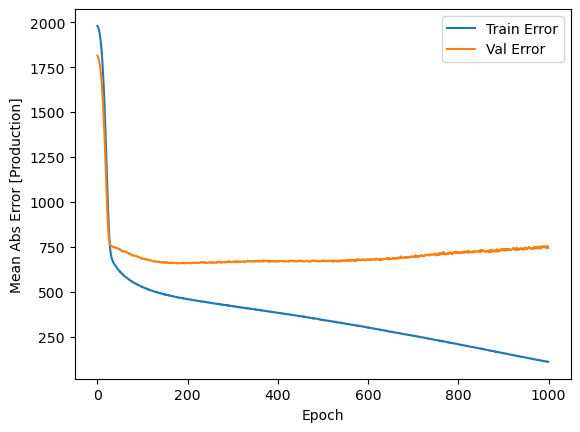

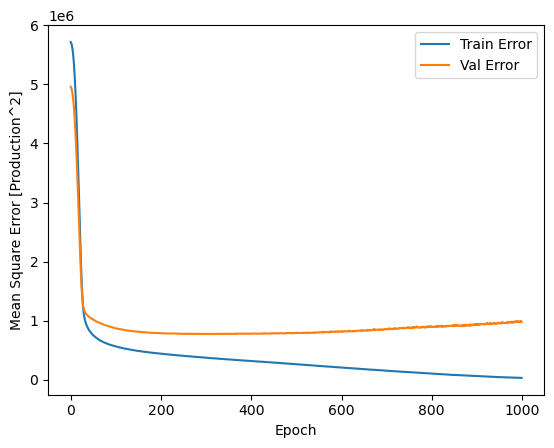

In [131]:
plot_history(history)


....................................................................................................
....................................................................................................
...........................

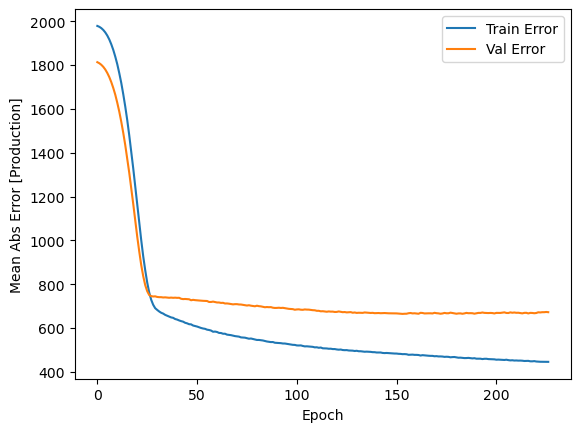

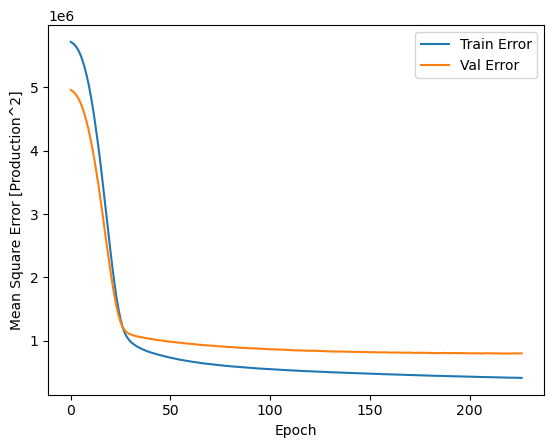

In [140]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train_norm, y_train, epochs=EPOCHS,
                validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

In [141]:
loss, mae, mse = model.evaluate(X_test_norm, y_test, verbose=2)

7/7 - 0s - loss: 719874.6250 - mae: 611.8149 - mse: 719874.6250 - 148ms/epoch - 21ms/step


In [142]:
test_predictions = model.predict(X_test_norm).flatten()

7/7 [==============================] - 0s 2ms/step


In [144]:
np.mean(test_predictions)

1975.4619

In [145]:
np.mean(y_test)

1957.8917210485006

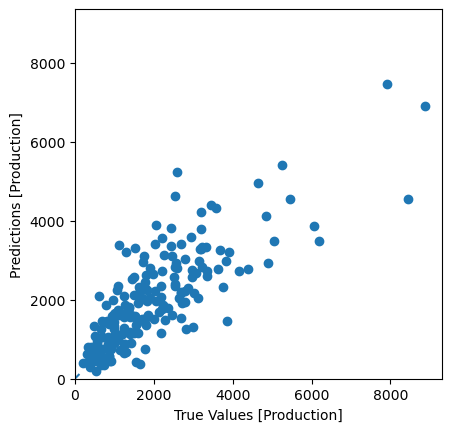

In [150]:

#Plotting scatter plot of predicted vs actual values
def plot_scatter_real_vs_predicted():
    plt.scatter(y_test, test_predictions)
    plt.xlabel('True Values [Production]')
    plt.ylabel('Predictions [Production]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])

In [138]:
def plot_distribution(y_true, y_pred):
    sns.distplot(y_true, color='r', label='real production');
    sns.distplot(y_pred, color='b', label='predicted production');
    plt.legend();

In [156]:
model.save('../../models/model_neural_network.h5')

In [159]:
new_model = load_model('../../models/model_neural_network.h5')

7/7 [==============================] - 0s 2ms/step


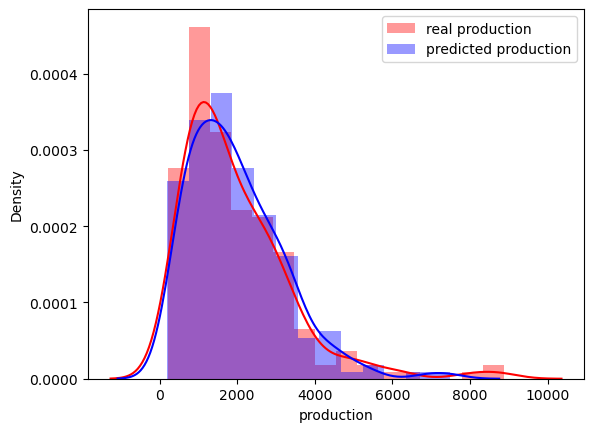

In [161]:
def plot_distribution(y_true, y_pred):
    sns.distplot(y_true, color='r', label='real production');
    sns.distplot(y_pred, color='b', label='predicted production');
    plt.legend();
    
plot_distribution(y_test, new_model.predict(X_test_norm))

In [162]:
new_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 64)                5632      
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
